'''
This talk was from Sam tensorfow talk. 
Code heavily adapted from https://github.com/samwit/TensorFlowTalks/blob/master/talk3/Super%20Resolution%20for%20TF%20Talk-GPU-2k-8x-Presentation.ipynb

Super Resolution using Perceptual Loss
Based on "Perceptual Losses for Real-Time Style Transfer and Super-Resolution" by Johnson et.al http://arxiv.org/abs/1603.08155

Rationale : Improving image resolution with apparant 'pixelation' in a quick and fast manner. 
Time taken : 1hr to train and source images. 

'''


In [1]:

from __future__ import print_function
from __future__ import absolute_import

import warnings
import sys
sys.path.append('../../')
from keras.models import Model
from keras import layers
from keras.layers import Activation
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Flatten, Reshape, Dropout, merge, Lambda
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD
from keras.layers import BatchNormalization
from keras.layers import Conv2D,Conv2DTranspose,UpSampling2D
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.engine.topology import get_source_inputs
from keras.utils.data_utils import get_file
from keras import backend as K
#from imagenet_utils import decode_predictions
#from imagenet_utils import _obtain_input_shape
import tensorflow as tf
#import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras import optimizers
import keras

print('TensorFlow:',tf.__version__)
print('Keras:',keras.__version__)


Using TensorFlow backend.


TensorFlow: 1.4.0
Keras: 2.0.8


In [2]:
''' 
defining  the upsampling blocks
'''
def conv_block(x, num_filters, filter_size, stride=(2,2), mode='same', act=True):
    x = Conv2D(num_filters, (filter_size, filter_size), strides=stride, padding=mode)(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x) if act else x

def res_block(initial_input, num_filters=64):
    x = conv_block(initial_input, num_filters, 3, (1,1))
    x = conv_block(x, num_filters, 3, (1,1), act=False)
    return merge([x, initial_input], mode='sum')

# Up Sampling block aka deconvolution
def up_block(x, num_filters, size):
    x = UpSampling2D()(x)
    x = Conv2D(num_filters, (size, size), padding='same')(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

# Load data
arr_hr = np.load('High_res.npy')
arr_lr = np.load('Low_res.npy')



'''
Music scores , Original (Left), Pixelated (Right)
The scores were resized using python cv2 command using bilinear interpolation
to obtain train and test sets. 
'''

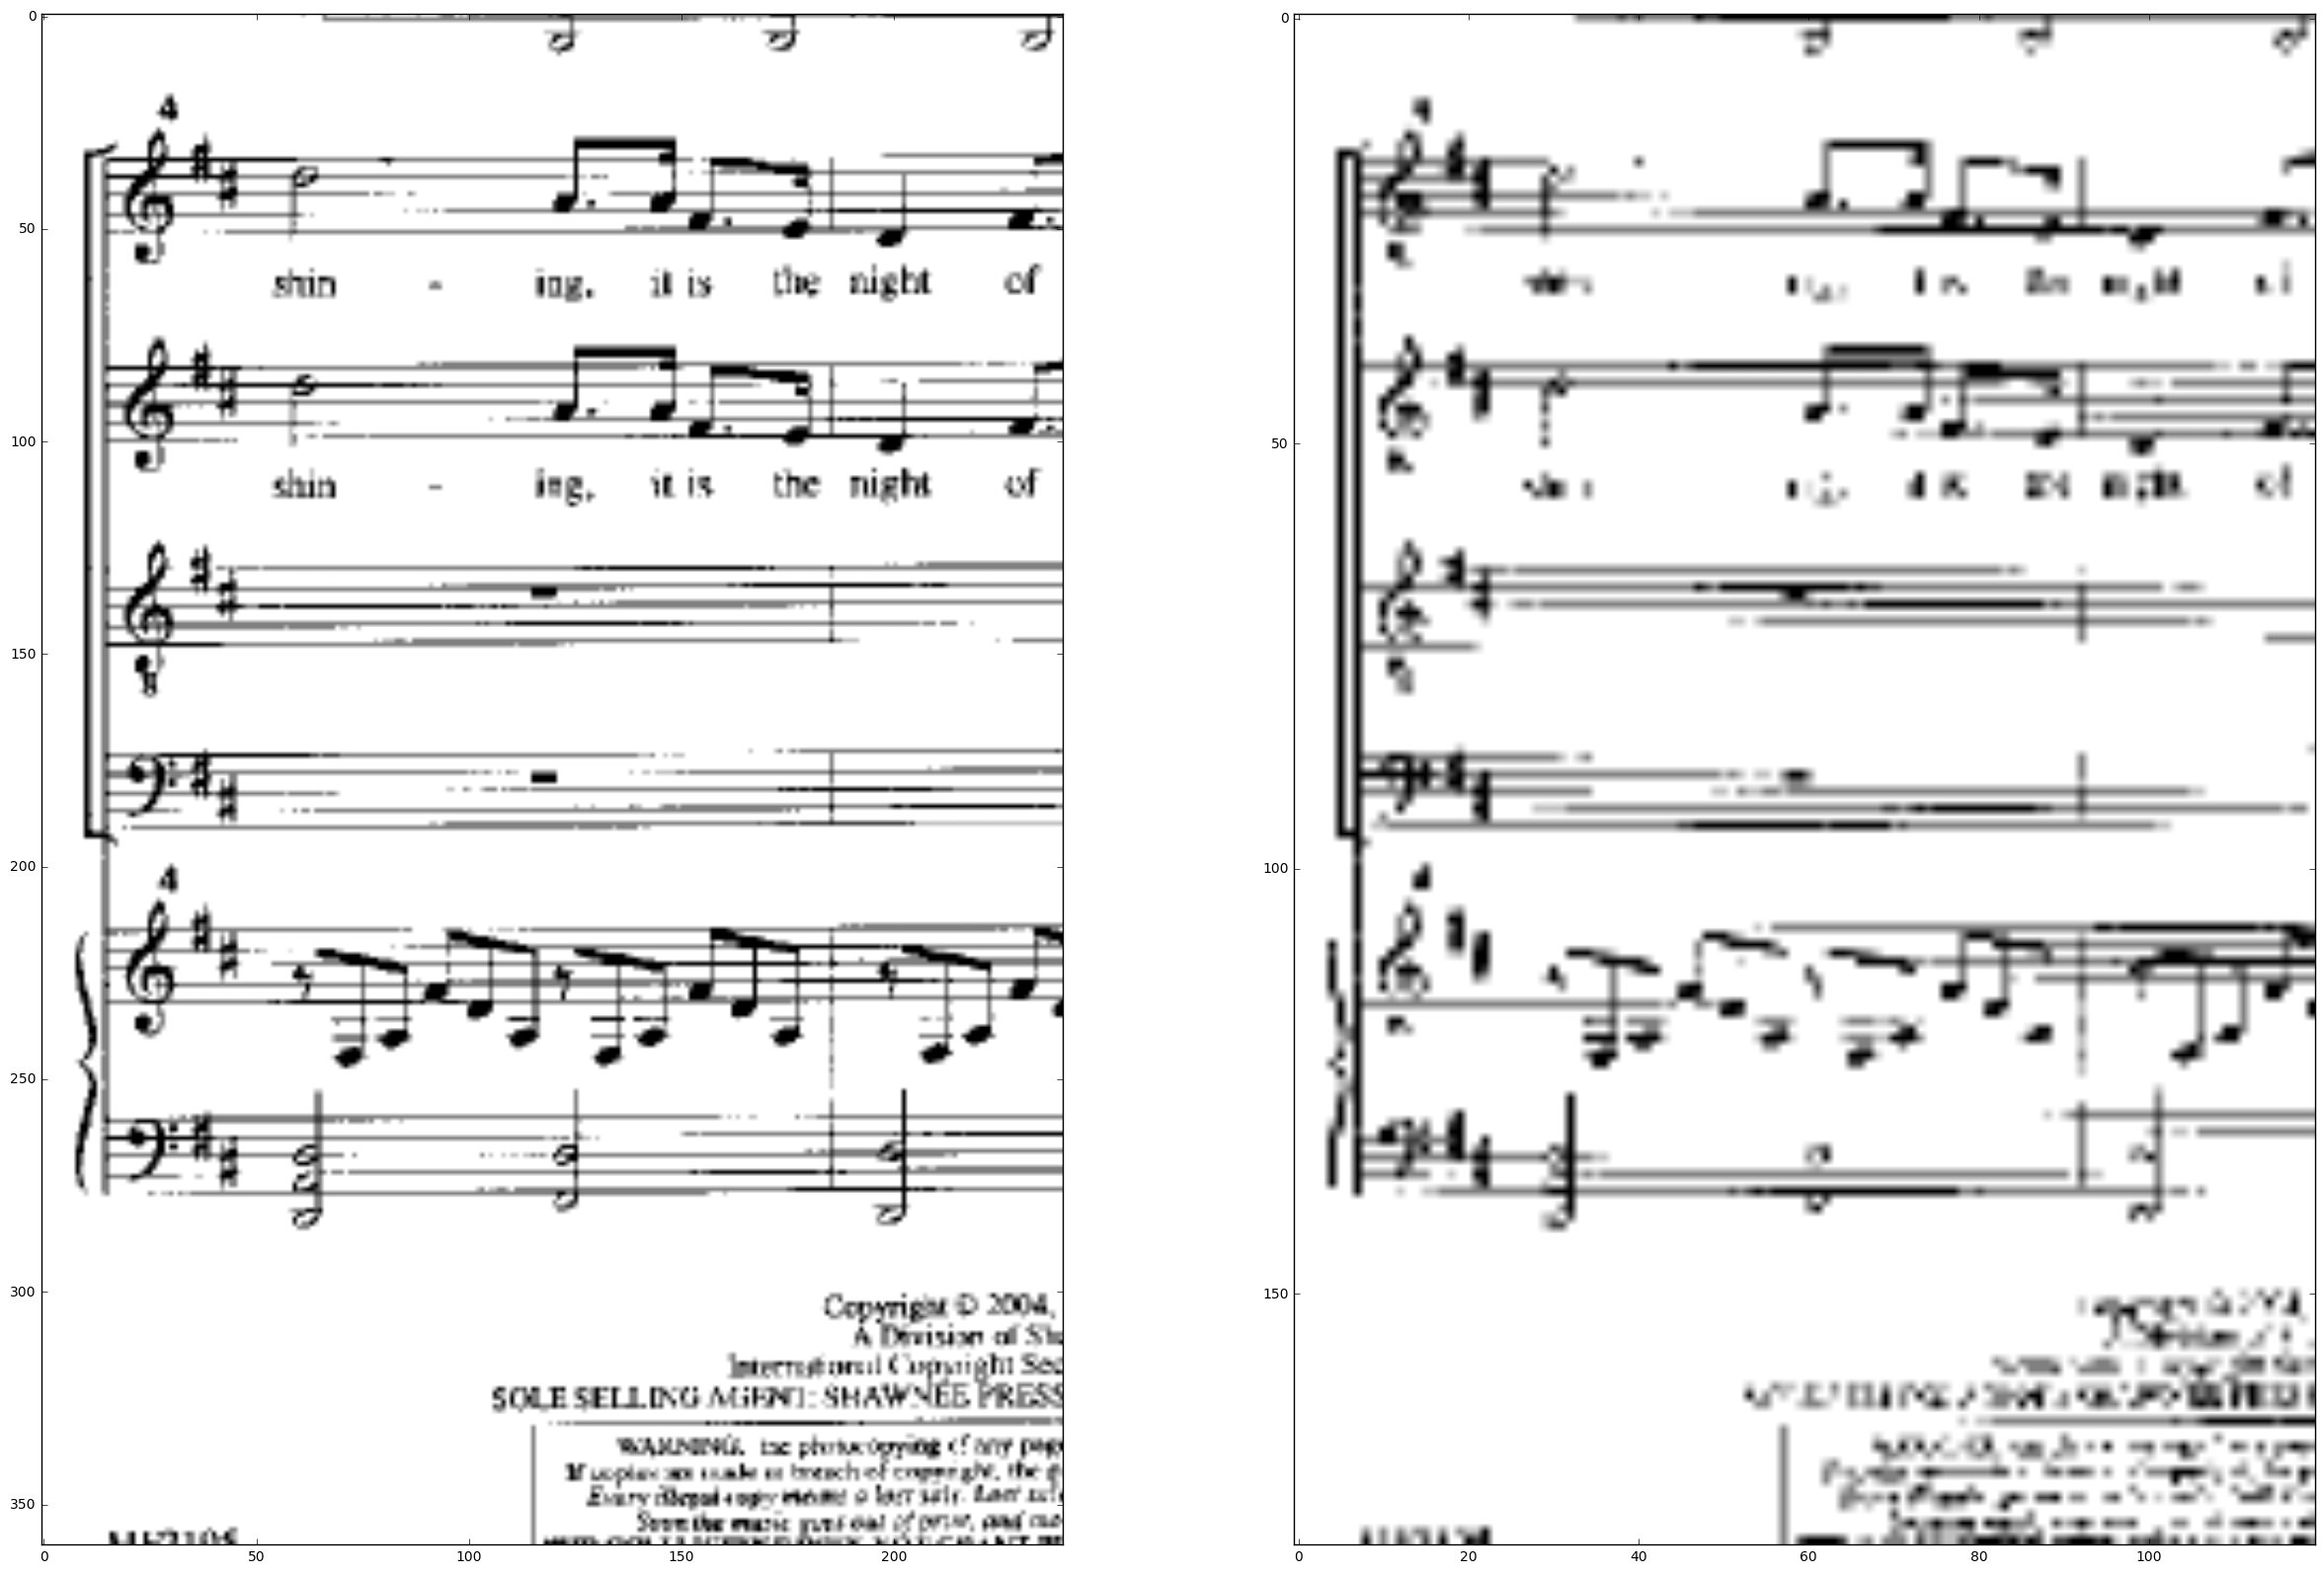

In [3]:
fig, axs = plt.subplots(1,2,figsize=(30,20))
axs[0].imshow(arr_hr[0]);
axs[1].imshow(arr_lr[0])
plt.show()

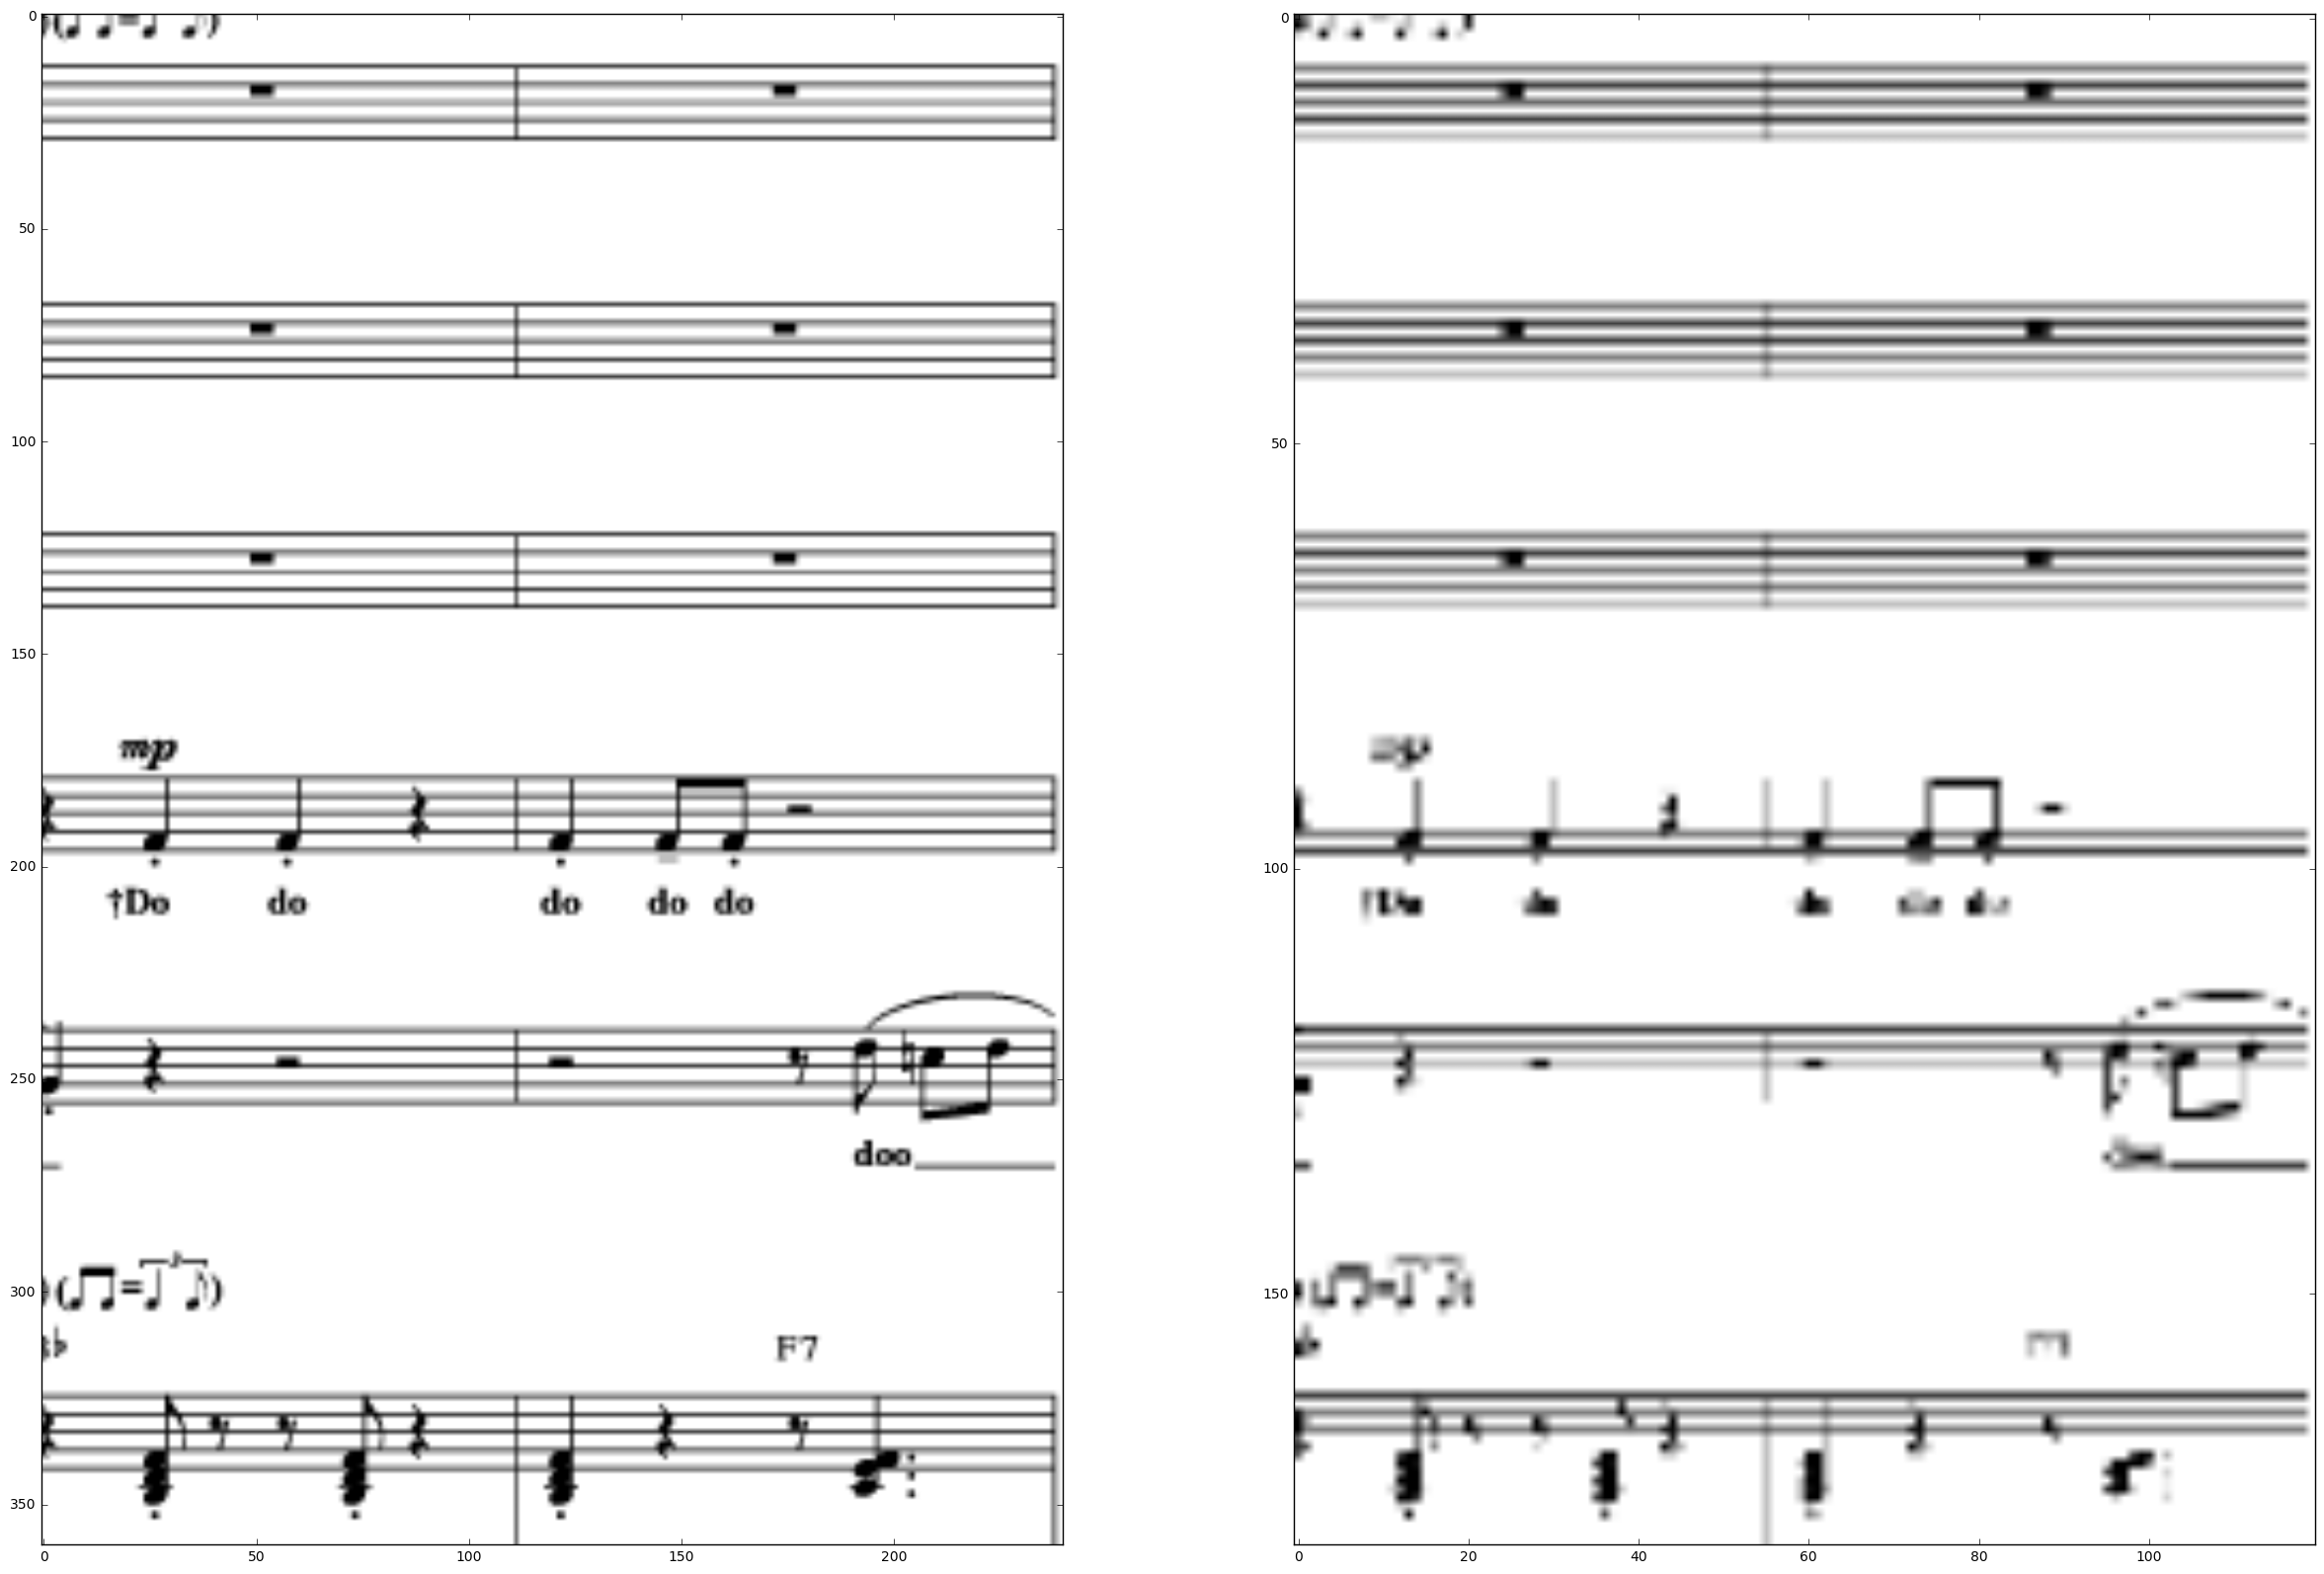

In [4]:
fig, axs = plt.subplots(1,2,figsize=(30,20))
axs[0].imshow(arr_hr[-100]);
axs[1].imshow(arr_lr[-100])
plt.show()

In [5]:
# This is out upscale model
def get_upsampling_model_2x(arr_lr):
    inp=Input(arr_lr.shape[1:])
    x=conv_block(inp, 64, 9, (1,1))
    x=res_block(x)
    x=res_block(x)
    x=res_block(x)
    x=res_block(x)
    x=up_block(x, 64, 3)
    x=Conv2D(3, (9, 9), activation='tanh', padding='same')(x)
    outp=Lambda(lambda x: (x+1)*127.5)(x) # this restores to a normal image
    return inp,outp
'''
Notes

1x1 convs with large 9 lets us have a larger receptive field

The Tanh gets us between -1,1
+1 * 127.5 gets the 0-255 back

'''

'\nNotes\n\n1x1 convs with large 9 lets us have a larger receptive field\n\nThe Tanh gets us between -1,1\n+1 * 127.5 gets the 0-255 back\n\n'

In [6]:
# this gets the output from the model
upsampled_inp,upsampled_output = get_upsampling_model_2x(arr_lr) 

# we define the tensor sizes by giving it the example tensor
up_model2 = Model(upsampled_inp,upsampled_output)
up_model2.summary() #upscales from 180*120*3 to 360*240*3

/home/leexa/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/leexa/anaconda2/lib/python2.7/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 180, 120, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 180, 120, 64)  15616       input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 180, 120, 64)  256         conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 180, 120, 64)  0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [7]:
'''
We will now use the VGG pre_trained model (image classfication model) to get the loss, 
and will elaborate in the next section
'''
#vgg input 
vgg_inp=Input(arr_hr.shape[1:])

#vgg network
vgg= keras.applications.VGG16(include_top=False, input_tensor=vgg_inp)
for l in vgg.layers: l.trainable=False  # can't have loss function be trainable

# Lambda makes a layer of a function/ this makes the preprocessing a layer
# This preprocesses our normal images to make them ready for VGG 
#preproc_layer = Lambda(preproc)


# get the vgg output 
vgg_out_layer = vgg.get_layer('block2_conv2').output

# making model Model(inputs, outputs)
vgg_content = Model(vgg_inp, vgg_out_layer)

vgg_content.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 360, 240, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 360, 240, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 360, 240, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 180, 120, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 180, 120, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 180, 120, 128)     147584    
Total params: 260,160
Trainable params: 0
Non-trainable params: 260,160
_________________________________________________________________


In [8]:
'''
We will feed the predicted images and original from block2_conv2 (Conv2D) ,
and minimize the mse of outputs between the high resolution and predicted image  
'''

# this is the VGG model with the HR input
vgg_hr_image = vgg_content(vgg_inp)

# this is the upsampled network
vgg_upsampled_output = vgg_content(upsampled_output)



# Mean Sum of Squared Errors on the outputs of the 2 VGG nets
loss = Lambda(lambda x: K.sqrt(K.mean((x[0]-x[1])**2, (1,2))))\
       ([vgg_hr_image, vgg_upsampled_output])

super_res_model = Model([upsampled_inp, vgg_inp], loss)
super_res_model.compile('adam', 'mse')

In [ ]:
# we need a target for the network to train to
targ = np.zeros((arr_hr.shape[0], 128))
# define batch_generator since images are too large to fit into memory
def batch_generator(X, y, batch_size,shuffle=True):
    np.random.seed(2)
    number_of_batches = y.shape[0]/batch_size
    counter=0
    shuffle_index = np.arange(y.shape[0])
    if shuffle is True:
        np.random.shuffle(shuffle_index,)
    X[0] =  X[0][shuffle_index, :,:,:]
    X[1] =  X[1][shuffle_index, :,:,:]
    y =  y[shuffle_index,:]
    while 1:
        index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
        X_batch0 = X[0][index_batch,:,:,:]
        X_batch1 = X[1][index_batch,:,:,:]
        y_batch = y[index_batch,:]
        counter += 1
        if counter >= 1*len(y)//batch_size-1:
            counter = 0
            np.random.shuffle(shuffle_index,)
        yield([np.array(X_batch0),np.array(X_batch1)],np.array(y_batch))
# split 50 train 50 test
tr_generator = batch_generator([arr_lr[0::2], arr_hr[0::2]],targ[0::2],1) #yes i know its only 1
val_generator = batch_generator([arr_lr[1::2], arr_hr[1::2]],targ[1::2],2)


In [ ]:
# fit the model
model_path = 'keras_model.h5'
callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=3, # was 10
            verbose=0),
        
        ModelCheckpoint(
            model_path, 
            monitor='val_loss',
            save_best_only=True, 
            verbose=0)
    ]

super_res_model.fit_generator(tr_generator,callbacks=callbacks,
                                  steps_per_epoch=len(arr_lr[0::2])//2,
                                  epochs=20,
                                  verbose=1,
                                  validation_data=val_generator,
                                  validation_steps=len(arr_lr[1::2])//2)
'''
I paused early in notebook, in actuality i ran on 1200 pictures dataset once. 
Val loss was about 70K. Cross validation was done with my EYES since i wanted a quick solution
'''

Epoch 1/20
23/62 [==========>...................] - ETA: 346s - loss: 603613.5564

In [ ]:
# saving up_model2 weights, not saving the VGG ones
up_model2.save_weights('save_weights.h5')
up_model2.load_weights('../../temp_x2_69k.h5') #Fully trained model outside the notebook 


In [ ]:
# this gets the output from the model
upsampled_inp,upsampled_output = get_upsampling_model_2x(arr_hr) 

# we define the tensor sizes by giving it the example tensor
up_model3 = Model(upsampled_inp,upsampled_output)
up_model3.load_weights('./weights/pretrained_save_weights.h5')
x = up_model2.predict(arr_lr[-100:-99])
y = up_model3.predict(arr_hr[-100:-99])

In [ ]:
'''
Now we try improving the resolution of the original image to 2x the size
'''
fig, axs = plt.subplots(2,2,figsize=(50,50))
axs[0,0].imshow(arr_lr[-100][85:160,0:75,:]);
axs[0,1].imshow(x[0].astype(np.uint8)[170:320,0:150,:]);
axs[1,0].imshow(arr_hr[-100][170:320,0:150,:])
axs[1,1].imshow(y[0].astype(np.uint8)[340:640,0:300,:])
axs[0,0].set_xlabel('120*180*3',fontsize = 60)
axs[0,1].set_xlabel('upscaled model of left = 240*360*3',fontsize = 60)
axs[1,0].set_xlabel('240*360*3',fontsize = 60)
axs[1,1].set_xlabel('upscaled model of left = 720*360*3',fontsize = 60)
plt.show();plt.clf()

'''
From above, the model is unable to read poorly defined images. (first row above)
BUt it is able to resize well-defined images. (second row above)
'''

In [ ]:
'''
Lets upscale again to 1440 720
'''
# this gets the output from the model
upsampled_inp,upsampled_output = get_upsampling_model_2x(y) 

# we define the tensor sizes by giving it the example tensor
up_model4 = Model(upsampled_inp,upsampled_output)
up_model4.load_weights('../../temp_x2_69k.h5')
z = up_model4.predict(y)

In [ ]:
'''
Now we try improving the resolution of the original image to 4x the size
The model is pretty good at increasing the resolution, and can be used repeatedly.
Below is the same image in three zooms. 
'''

In [ ]:
fig, axs = plt.subplots(3,3,figsize=(75,75))
axs[0,0].imshow(arr_hr[-100])
axs[0,1].imshow(y[0].astype(np.uint8))
axs[0,2].imshow(z[0].astype(np.uint8))
axs[0,0].set_xlabel('ORI 240*360*3',fontsize = 60)
axs[0,1].set_xlabel('X2 720*360*3',fontsize = 60)
axs[0,2].set_xlabel('X4 1440*720*3',fontsize = 60)

axs[1,0].imshow(arr_hr[-100][170:320,0:150,:])
axs[1,1].imshow(y[0].astype(np.uint8)[340:640,0:300,:])
axs[1,2].imshow(z[0].astype(np.uint8)[340*2:640*2,0:300*2,:])
axs[1,0].set_xlabel('ORI 240*360*3',fontsize = 60)
axs[1,1].set_xlabel('X2 720*360*3',fontsize = 60)
axs[1,2].set_xlabel('X4 1440*720*3',fontsize = 60)

axs[2,0].imshow(arr_hr[-100][170:220,0:50,:])
axs[2,1].imshow(y[0].astype(np.uint8)[340:440,0:100,:])
axs[2,2].imshow(z[0].astype(np.uint8)[340*2:440*2,0:100*2,:])
axs[2,0].set_xlabel('ORI 240*360*3',fontsize = 60)
axs[2,1].set_xlabel('X2 720*360*3',fontsize = 60)
axs[2,2].set_xlabel('X4 1440*720*3',fontsize = 60)
plt.savefig('Differrent_resolution.png')
plt.show();plt.clf()